In [1]:
import patsy 
import numpy as np
import scipy as sp
import pandas as pd
import sklearn as sk
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from statsmodels.graphics import utils
from sklearn.model_selection import KFold
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()

/Users/Dong-hyun/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [31]:
df = pd.read_csv('./data/train.csv')
pd.set_option('display.max_rows', 1000)
df = df.set_index('AnimalID')


df.tail()

,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
AnimalID,,,,,,,,,
A702446,NaN,2015.5.14 11:56,Transfer,Partner,Cat,Intact Male,1 month,Domestic Shorthair Mix,Brown Tabby/White
A718934,NaN,2016.1.20 18:59,Transfer,SCRP,Cat,Spayed Female,3 months,Domestic Shorthair Mix,Brown Tabby
A698128,Zeus,2015.3.9 13:33,Adoption,NaN,Dog,Neutered Male,4 years,Old English Bulldog Mix,White/Tan
A677478,NaN,2014.4.27 12:22,Transfer,Partner,Cat,Intact Male,4 weeks,Domestic Shorthair Mix,Black
A706629,NaN,2015.7.2 9:00,Transfer,SCRP,Cat,Intact Male,1 year,Domestic Shorthair Mix,Brown Tabby/White


In [3]:
df.describe()

,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,19038,26729,26729,13117,26729,26728,26711,26729,26729
unique,6374,22918,5,16,2,5,44,1380,366
top,Max,2015.8.11 0:00,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,136,19,10769,7816,15595,9779,3969,8810,2824


In [4]:
df.keys()

Index(['Name', 'DateTime', 'OutcomeType', 'OutcomeSubtype', 'AnimalType',
       'SexuponOutcome', 'AgeuponOutcome', 'Breed', 'Color'],
      dtype='object')

In [5]:
dfy = pd.DataFrame(df, columns=['OutcomeType'])
dfx = df.drop('OutcomeType', axis=1)

In [6]:
dfx.describe()

,Name,DateTime,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,19038,26729,13117,26729,26728,26711,26729,26729
unique,6374,22918,16,2,5,44,1380,366
top,Max,2015.8.11 0:00,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,136,19,7816,15595,9779,3969,8810,2824


In [24]:
df['AnimalType'].value_counts()

Dog    15595
Cat    11134
Name: AnimalType, dtype: int64

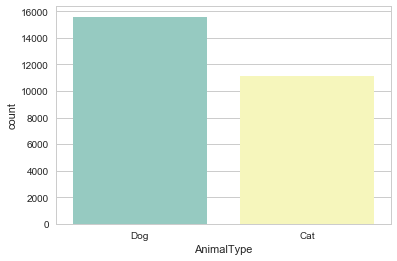

In [7]:
sns.countplot(df.AnimalType, palette='Set3')
plt.show()

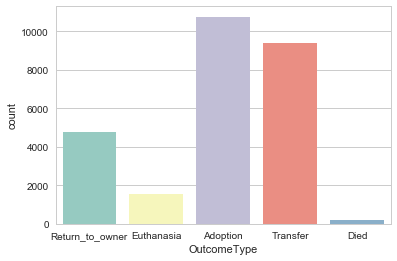

In [8]:
sns.countplot(df.OutcomeType, palette='Set3')
plt.show()

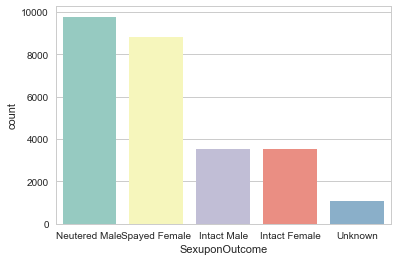

In [9]:
sns.countplot(df.SexuponOutcome, palette='Set3')
plt.show()

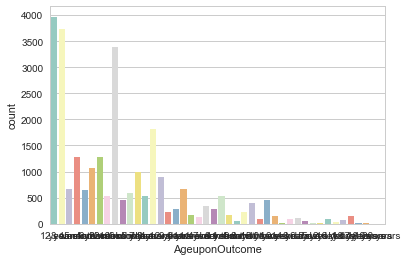

In [10]:
sns.countplot(df.AgeuponOutcome, palette='Set3')
plt.show()

### 너무 세분화 되어 있어서 데이터로 활용하기 어렵고, 인사이트를 뽑아내기도 애매하다. 단순화작업이 필요

In [11]:
def calc_age_in_years(x):
    x = str(x)
    if x == 'nan': return 0
    age = int(x.split()[0])
    if x.find('year') > -1: return age 
    if x.find('month')> -1: return age / 12.
    if x.find('week')> -1: return age / 52.
    if x.find('day')> -1: return age / 365.
    else: return 0

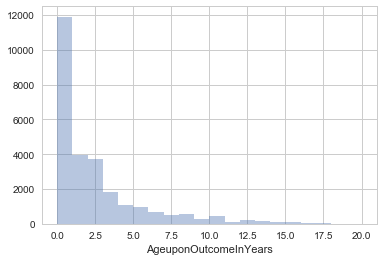

In [12]:
df['AgeuponOutcomeInYears'] = df.AgeuponOutcome.apply(calc_age_in_years)
sns.distplot(df.AgeuponOutcomeInYears, bins = 20, kde=False)
plt.show()

In [13]:
def calc_age_category(x):
    if x < 3: return 'young'
    if x < 5: return 'young adult'
    if x < 10: return 'adult'
    return 'old'
df['AgeCategory'] = df.AgeuponOutcomeInYears.apply(calc_age_category)

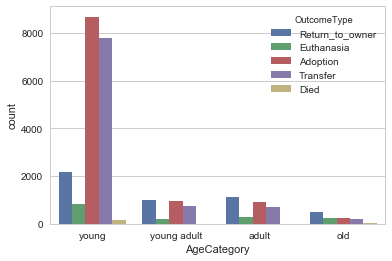

In [14]:
sns.countplot(data=df, x='AgeCategory',hue='OutcomeType')
plt.show()

## 3세 미만의 어린 개와 고양이가 입양 및 이관비율이 다른 연령대에 비해 압도적으로 높다. 
## 10세 이상은 주인에게 돌아가는 비율이 다른 연령대에 비해 상대적으로 높다. 
* Modeling 시에 연령(1년단위)로 사용할지, 연령그룹(young/young adult/...)으로 사용할지는 선택이 필요함.

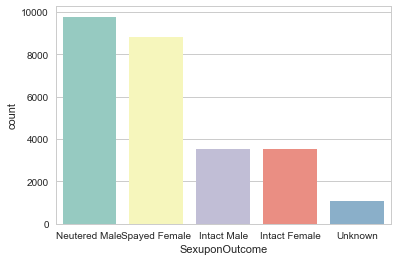

In [16]:
sns.countplot(df.SexuponOutcome, palette='Set3')
plt.show()

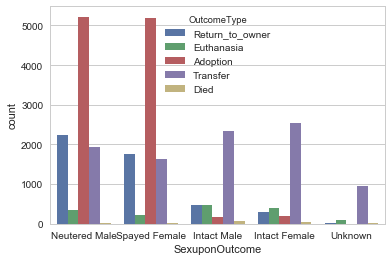

In [15]:
sns.countplot(data=df, x='SexuponOutcome',hue='OutcomeType')
plt.show()

## 중성화 수술이 된 쪽이 자연상태인 쪽보다 주인이 찾아가는 비율과 입양되는 비율이 압도적으로 높았다. 
## 자연상태의 개와 고양이는 이관되는 비율이 압도적으로 높다.

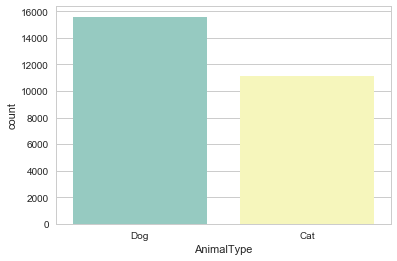

In [17]:
sns.countplot(df.AnimalType, palette='Set3')
plt.show()

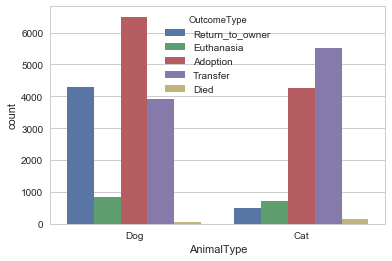

In [18]:
sns.countplot(data=df, x='AnimalType',hue='OutcomeType')
plt.show()

## 주인이 다시 찾아가는 비율은 개가 고양이에 비해서 압도적으로 높다.

In [32]:
df['Breed'].value_counts()

Domestic Shorthair Mix                                    8810
Pit Bull Mix                                              1906
Chihuahua Shorthair Mix                                   1766
Labrador Retriever Mix                                    1363
Domestic Medium Hair Mix                                   839
German Shepherd Mix                                        575
Domestic Longhair Mix                                      520
Siamese Mix                                                389
Australian Cattle Dog Mix                                  367
Dachshund Mix                                              318
Boxer Mix                                                  245
Miniature Poodle Mix                                       233
Border Collie Mix                                          229
Australian Shepherd Mix                                    163
Rat Terrier Mix                                            157
Catahoula Mix                                          

In [ ]:
df_